### Inference: How to generate novel attribute compositions, ones the model is trained
For training documentation follow README.md

In [8]:
#typically for load model from the config but its okay we will define the config as a dict
import sys
import os
parent_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(parent_dir)

import torch
import pytorch_lightning as pl
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from matplotlib import cm
from typing import Optional
import functools
import seaborn as sns
import math
import hydra
import torchvision
from diffusers import DDPMScheduler,AutoencoderKL,UNet2DModel

from coind.models.conditional_unet import ClassConditionalUnet
# from coind.score.pipelines import CondDDIMPipeline



import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Union, List
from diffusers.pipelines.pipeline_utils import ImagePipelineOutput
from diffusers.utils.torch_utils import randn_tensor
from diffusers import DDIMPipeline,DDPMPipeline
from diffusers.pipelines.pipeline_utils import DiffusionPipeline





if torch.cuda.is_available():
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'  # Use GPU 1
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

Using gpu


In [9]:
model_config = {
    '_target_': ClassConditionalUnet,
    'num_class_per_label': [2,2],
    'interaction': 'sum',
    'sample_size': 64,
    'in_channels': 3,
    'out_channels': 3, 
    'center_input_sample': False,
    'time_embedding_type': 'positional'
}

scheduler_config = {
    '_target_': DDPMScheduler,
    'num_train_timesteps': 1000,
    'clip_sample': True,
    "prediction_type": 'epsilon',
    'beta_schedule': 'squaredcos_cap_v2',
}
checkpoints = {    
    "vanilla": "/research/hal-gaudisac/Diffusion/compositional-generation/outputs/2025-03-04/23-59-59/tensorboard/version_0/checkpoints/epoch=114-step=500000.ckpt",
    "coind": "/research/hal-gaudisac/Diffusion/compositional-generation/outputs/2025-03-04/23-56-46/tensorboard/version_0/checkpoints/epoch=114-step=500000.ckpt",
}


In [10]:
model = hydra.utils.instantiate(model_config).to(device)
scheduler = hydra.utils.instantiate(scheduler_config)

#load model
checkpoint_path = checkpoints['coind']
model_state_dict = {k.replace('model.',''): v for k, v in torch.load(checkpoint_path)['state_dict'].items() if k.startswith('model.')}
model.load_state_dict(model_state_dict, strict=False)

/tmp/ipykernel_158866/4170613813.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = {k.replace('model.',''): v for k, v in torch.load(checkpoint_path)['s

<All keys matched successfully>

In [110]:
class CondDDIMPipeline(DDIMPipeline):
    def __init__(self, unet, scheduler,vae: Optional[AutoencoderKL] = None):
        super().__init__(unet, scheduler)
        self.vae = vae
        self.register_modules(vae=vae)
    """
    A PyTorch Lightning module that implements the DDIM pipeline for image data. Taken from the original DDIM implementation."""
    @torch.no_grad()
    def __call__(
        self,
        batch_size: int = 1,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        eta: float = 0.0,
        num_inference_steps: int = 50,
        use_clipped_model_output: Optional[bool] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        query: Optional[torch.Tensor] = None,
        guidance_scale: Union[float,int,torch.Tensor] = 0.0,
        null_token: Optional[torch.Tensor] = None,
        image: Optional[torch.Tensor] = None,
        **kwargs,
    ):
        if isinstance(self.unet.config.sample_size, int):
            image_shape = (
                batch_size,
                self.unet.config.in_channels,
                self.unet.config.sample_size,
                self.unet.config.sample_size,
            )
        elif self.unet.config.in_channels ==0:
            image_shape = (batch_size, *self.unet.config.sample_size)
        else:
            image_shape = (batch_size, self.unet.config.in_channels, *self.unet.config.sample_size)

        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        if image is None:
            image = randn_tensor(image_shape, generator=generator, device=self.unet.device, dtype=self.unet.dtype)
    
        self.scheduler.set_timesteps(num_inference_steps)
        if 'noise_percentage' in kwargs:
            timesteps = torch.ones(images.size(0), device=device, dtype=torch.long)*self.scheduler.timesteps[int(len(self.scheduler.timesteps)*kwargs['noise_percentage'])]
            noise = torch.randn_like(image)
            image = scheduler.add_noise(image,noise ,timesteps)
            self.scheduler.timesteps =self.scheduler.timesteps[int(len(self.scheduler.timesteps)*kwargs['noise_percentage'])+1:]

        plt.imshow(torchvision.utils.make_grid(image.detach().cpu()*0.5+0.5, nrow=4).permute(1,2,0))
        plt.axis('off')
        plt.show()

        if query is not None:
            image = image.to(device=query.device)
        for t in self.progress_bar(self.scheduler.timesteps):
            
            # 2. predict previous mean of image x_t-1 and add variance depending on eta
            # eta corresponds to η in paper and should be between [0, 1]
            # do x_t -> x_t-1
            #train_timesteps
            model_output = self.unet(image, t,query, guidance_scale=guidance_scale, null_token=null_token)
            image = self.scheduler.step(
                model_output, t, image, eta=eta, use_clipped_model_output=use_clipped_model_output, generator=generator
            ).prev_sample

        if self.vae is not None:
            image = self.vae.decode(image/self.vae.config.scaling_factor)[0]
        if not return_dict:
            return (image,)
        return ImagePipelineOutput(images=image)

In [111]:
class ModelWrapper(UNet2DModel):
    def __init__(self, model):
        super().__init__()
        self.model = model
    @torch.no_grad()
    def forward(self, x, t, y):
        raise NotImplementedError
    #config should be same as the model
    @property
    def config(self):
        return self.model.config

class ANDquery(ModelWrapper):

    def forward(self, x, t, y, **kwargs):
        # query, guidance_scale, null_token
        
        if 'null_token' not in kwargs:
            raise ValueError('null_token is not provided')    
        
        null_token = kwargs['null_token']
        query = self.prepare_and_query(y,null_token)
        B,Q,D = query.size()

        if 'guidance_scale' in kwargs:
            if isinstance(kwargs['guidance_scale'], float):
                guidance_scale = [kwargs['guidance_scale']]*Q
            else:
                guidance_scale = kwargs['guidance_scale']
        else:
            guidance_scale = [7.5]*Q

        model_in = torch.cat([x]*(Q+1), 0)
        query = query.transpose(1, 0).reshape(B*Q, D)
        query = torch.cat([null_token, query], 0)
        model_output = self.model(model_in, t, query)
        chunk_model_output = model_output.chunk(Q+1, dim=0)
        model_output = chunk_model_output[0] + sum([guidance_scale[i]*(chunk_model_output[i+1] - chunk_model_output[0]) for i in range(Q)])
        return model_output
    def prepare_and_query(self,y,null_token):
        B,Q = y.size()
        query = null_token.repeat(Q,1).to(dtype=y.dtype,device=y.device)
        query = query.reshape(B,Q,Q)
        for i in range(Q):
            query[:,i,i] = y[:,i]
        return query

class CFGquery(ModelWrapper):

    def forward(self, x, t, y, **kwargs):
        # query, guidance_scale, null_token
        
        if 'null_token' not in kwargs:
            raise ValueError('null_token is not provided')    
        
        null_token = kwargs['null_token']

        guidance_scale = kwargs.get('guidance_scale', 7.5)

        model_in = torch.cat([x]*(2), 0)
        query = torch.cat([null_token, y], 0)
        model_output = self.model(model_in, t, query)
        chunk_model_output = model_output.chunk(2, dim=0)
        model_output = chunk_model_output[0] + guidance_scale*(chunk_model_output[1] - chunk_model_output[0])
        return model_output

model.eval()
and_model = ANDquery(model).to(device)
cfg_model = CFGquery(model).to(device)
pipeline = CondDDIMPipeline(and_model,scheduler=scheduler)


In [112]:
import ipywidgets as widgets
from IPython.display import display
gender_dropdown = widgets.Dropdown(options=[ 'Female','Male'], description='Gender:')
blond_dropdown = widgets.Dropdown(options=['Blond', 'Non-Blond'], description='Blond:')

gender_slider = widgets.IntSlider(description='Gender Control:', min=1, max=21, value=7.0)
blond_slider = widgets.IntSlider(description='Blond Control:', min=1, max=21, value=7.0)
# seed = widgets.IntText(description='Seed:', value=0)


#number of images

button = widgets.Button(description="Run")
output = widgets.Output()

display(gender_dropdown, blond_dropdown,gender_slider,blond_slider,button, output)#

seed = 42
def on_button_click(b):
    with output:
        output.clear_output()
        num_of_images = 16
        gender = int(gender_dropdown.value == 'Male')
        blond = int(blond_dropdown.value =="Blond")
        query =  torch.tensor([[gender, blond]]*num_of_images).to(device)
        guidance_scale = [gender_slider.value,blond_slider.value]
        null_token = torch.ones_like(query).to(device)*2
        num_inference_steps = 100
        set_seed(int(seed))
        generated_images = pipeline(batch_size=query.size(0), 
                        num_inference_steps= num_inference_steps,
                        return_dict= True,
                        use_clipped_model_output = True,
                        query = query,
                        guidance_scale=guidance_scale,
                        null_token=null_token)[0]
        generated_images = generated_images.cpu().detach()*0.5 + 0.5
        plt.figure(figsize=(10,10))
        #make a grid of images
        plt.imshow(torchvision.utils.make_grid(generated_images, nrow=4).permute(1,2,0))
        
        plt.axis('off')
        return generated_images

        #save images one by one
        # os.makedirs(f"../samples/vanilla_{gender_dropdown.value}_{blond_dropdown.value}", exist_ok=True)
        # for i in range(generated_images.size(0)):
        #     plt.imshow(generated_images[i].permute(1,2,0))
        #     plt.axis('off')
        #     plt.savefig(f'../samples/vanilla_{gender_dropdown.value}_{blond_dropdown.value}/{i}.png',bbox_inches='tight', pad_inches=0)
        
generated_images  = button.on_click(on_button_click)

Dropdown(description='Gender:', options=('Female', 'Male'), value='Female')

Dropdown(description='Blond:', options=('Blond', 'Non-Blond'), value='Blond')

IntSlider(value=7, description='Gender Control:', max=21, min=1)

IntSlider(value=7, description='Blond Control:', max=21, min=1)

Button(description='Run', style=ButtonStyle())

Output()

In [113]:
from  coind.datasets.celeba import BlondFemaleDataset,default_celeba_transform,blond_male_transform
original_data_path = '/research/hal-datastore/datasets/original/'
val_transform = default_celeba_transform('val')
original_data_val = BlondFemaleDataset(original_data_path, split='train',transforms=val_transform,target_transform=blond_male_transform())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5818508..2.6694798].


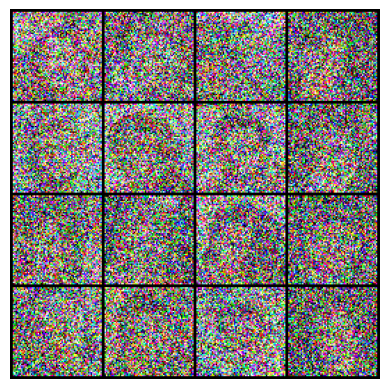

  0%|          | 0/79 [00:00<?, ?it/s]

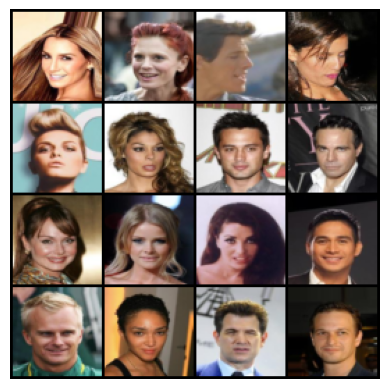

(-0.5, 265.5, 265.5, -0.5)

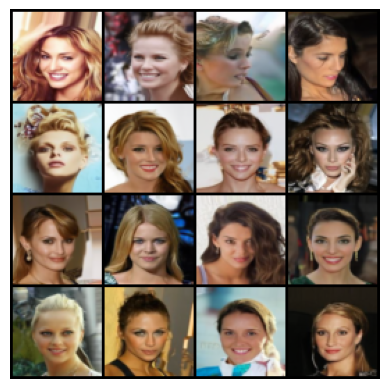

In [114]:
images = torch.vstack([original_data_val[i]['X'].unsqueeze(dim=0) for i in range(16)]).to(device)
query = torch.vstack([original_data_val[i]['label'].unsqueeze(dim=0) for i in range(16)]).to(device)
query = torch.tensor([[0,1]]*16).to(device)
guidance_scale = [7.5,7.5]
null_token = torch.ones_like(query).to(device)*2
generated_images = pipeline(batch_size=query.size(0), 
                num_inference_steps= 100,
                return_dict= True,
                use_clipped_model_output = True,
                query = query,
                image = images,
                guidance_scale=guidance_scale,
                noise_percentage=0.2,
                null_token=null_token)[0]
plt.imshow(torchvision.utils.make_grid(images.detach().cpu()*0.5+0.5, nrow=4).permute(1,2,0))
plt.axis('off')
plt.show()
plt.imshow(torchvision.utils.make_grid(generated_images.detach().cpu()*0.5+0.5, nrow=4).permute(1,2,0))
plt.axis('off')
